# Imports

In [1]:
import os
import requests
import json
import time
from matplotlib import pyplot as plt
import pandas as pd
from copy import deepcopy

#some helper functions
def print_settings(model_type, input_data):
    print('\t' + str(model_type) + ' model settings: ')
    print('\t\t' + str(model_type) + ' calculation type: ' + input_data['energyEfficienciesSettings'][str(model_type) + 'Model'][str(model_type) + 'ModelType'])
    for setting, value in input_data['energyEfficienciesSettings'][str(model_type) + 'Model'].items():
        if setting.lower() == input_data['energyEfficienciesSettings'][str(model_type) + 'Model'][str(model_type) + 'ModelType'].lower():
            print('\t\t\t'+str(setting)+': '+str(value))

def print_modeling_settings(input_data):
    print("Calling WindFarmer Services API...")
    print_settings('wake', input_data)
    print_settings('blockage', input_data)

# Let's verify if the `WindFarmer Services API` is alive and access is configurated correctly

In [2]:
api_url = 'https://windfarmer.dnv.com/api/v2/'
auth_token = os.environ['WINDFARMER_ACCESS_KEY']
headers = {
    'Authorization': f'Bearer {auth_token}',
    'Content-Type': 'application/json'
}
response = requests.get(api_url + 'Status', headers = headers)
print(json.loads(response.text)["message"])

Connection to DNV WindFarmer Services API was successful.


# Hypothetical (light-weight) wind farm in flat terrain: `The Smile`

The json containing inputs necessary to run an energy calculation in the cloud <b>can be easiy generated in DNV's WindFarmer:Analyst</b>, or can be compiled manually.

It contains:
 - layout geometry
 - turbine specs
 - wind resource information
 - model settings
 - ... 

The formal spec of the API is available here: https://windfarmer.dnv.com/documents 

Text(0.5, 1.0, 'The Smile - a hypothetical wind farm')

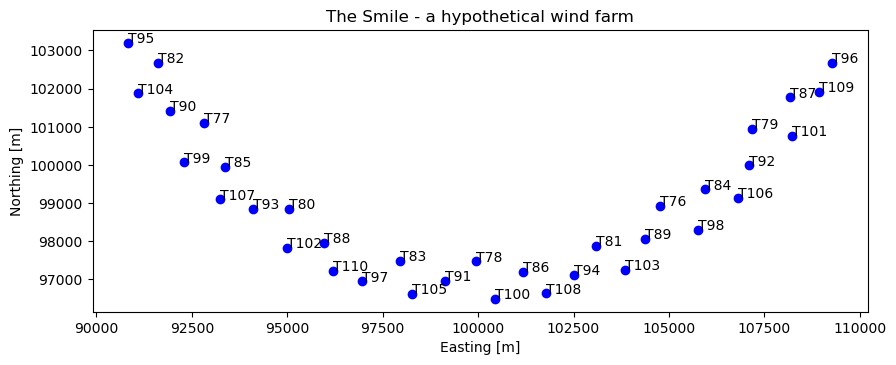

In [3]:
# Load wind farm definitnion from a json created in WindFarmer Desktop, or built from scratch.
with open('..\..\..\DemoData\TheBowl\TheBowl.json') as f:
    json_string = f.read()
    input_data = json.loads(json_string)

# in order to speed the example up, The Bowl wind farm is trimmed into The Smile
the_smile = ['T95', 'T104', 'T99', 'T107', 'T102', 'T110', 'T97', 'T105', 'T100', 'T108',
             'T103', 'T98', 'T106', 'T101', 'T109', 'T96', 'T82', 'T90','T77','T85','T93',
             'T80','T88','T83','T91','T78','T86','T94','T81','T89','T76','T84','T92','T79','T87']
turbines = [turbine for turbine in input_data['windFarms'][0]['turbines'] if turbine['name'] in the_smile]
input_data['windFarms'][0]['turbines'] = turbines

fig1, ax = plt.subplots(figsize=(10,4))
for wt in input_data['windFarms'][0]['turbines']:
    ax.scatter(wt['location']['easting_m'], wt['location']['northing_m'], c='b')
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    ax.set_aspect('equal', adjustable='box')
    ax.annotate(wt['name'],[wt['location']['easting_m'], wt['location']['northing_m']] )
ax.set_title('The Smile - a hypothetical wind farm')

# Calling  `WindFarmer Services API`, the `AnnualEnergyProduction` endpoint

#### Let's test a few wake & blockage modeling configurations as below:

In [4]:
inputs_dict = {}
# Version #1 - CFDML: 
input_data_v1 = deepcopy(input_data)
input_data_v1['energyEfficienciesSettings']['wakeModel']['wakeModelType'] = "CFDML"
input_data_v1["energyEfficienciesSettings"]["wakeModel"]["cfdml"]["gnnVersion"] = "1.1" # This calculator is only for gnn version 1
# CFD.ML models wake&blockage together, but CFDML will throw an error if blockage model is not set to CFDML, so we're setting it here, but this does not cause additional calculations
input_data_v1["energyEfficienciesSettings"]["blockageModel"]["blockageModelType"] = "CFDML"
inputs_dict['cfdml'] = input_data_v1


# Version #2: EddyViscosity wake model + Large WindFarm correction + BEET model to correct for blockage
input_data_v2 = deepcopy(input_data)
input_data_v2['energyEfficienciesSettings']['wakeModel']['wakeModelType'] = "EddyViscosity"
input_data_v2['energyEfficienciesSettings']['wakeModel']['eddyViscosity']['useLargeWindFarmModel'] = True
input_data_v2['energyEfficienciesSettings']['blockageModel']['blockageModelType'] = "BEET"
input_data_v2['energyEfficienciesSettings']['blockageModel']['beet']['blockageCorrectionApplicationMethod'] = "OnEnergy"
wake_settings_key = 'eddyViscosity'
inputs_dict['ev+lwf+beet'] = input_data_v2

# Version #3: as version 2, but applying BEET as an ambient windspeed perturbation
input_data_v3 = deepcopy(input_data_v2)
input_data_v3['energyEfficienciesSettings']['blockageModel']['beet']['blockageCorrectionApplicationMethod'] = "OnWindSpeed"
inputs_dict['ev+lwf+beet_ws'] = input_data_v3


#### Calling the API

In [5]:
def post_wfer_api_aep_calculation(input_data, url, headers):
    start = time.time()
    response = requests.post(
        url + 'AnnualEnergyProduction', 
        headers=headers,
        json = input_data)
    print(f'Response {response.status_code} - {response.reason} in {time.time() - start:.2f}s')
    # Print the error detail if we haven't receieved a 200 OK response
    if response.status_code != 200:
        print(json.loads(response.content)['detail'])
    return response    

responses_dict = {}
for k,v in inputs_dict.items():
    print_modeling_settings(v)    
    responses_dict[k] = post_wfer_api_aep_calculation(v, api_url, headers)

Calling WindFarmer Services API...
	wake model settings: 
		wake calculation type: CFDML
			cfdml: {'gnnType': 'Onshore', 'gnnVersion': '1.1'}
	blockage model settings: 
		blockage calculation type: NoBlockageModel
Response 200 - OK in 249.64s
Calling WindFarmer Services API...
	wake model settings: 
		wake calculation type: EddyViscosity
			eddyViscosity: {'useLargeWindFarmModel': True, 'largeWindFarmCorrectionParameters': {'baseRoughnessZ01': 0.02, 'increasedRoughnessZ02': 0.07, 'geometricWidthDiameters': 1.0, 'recoveryStartDiameters': 120.0, 'fiftyPercentRecoveryDiameters': 60.0}, 'useCloselySpacedTurbinesWakeModification': False, 'wakeProfileIntegrationMethod': 'Analytical'}
	blockage model settings: 
		blockage calculation type: BEET
			beet: {'significantAtmosphericStability': False, 'inclusionOfNeighborsBufferZoneInMeters': 1000.0, 'blockageCorrectionApplicationMethod': 'OnEnergy'}
Response 200 - OK in 2.76s
Calling WindFarmer Services API...
	wake model settings: 
		wake calcul

# The AEP results per turbine for the CFD.ML config

Wake & Blockage Affected Annual Energy Production = 475606.2 MWh / year


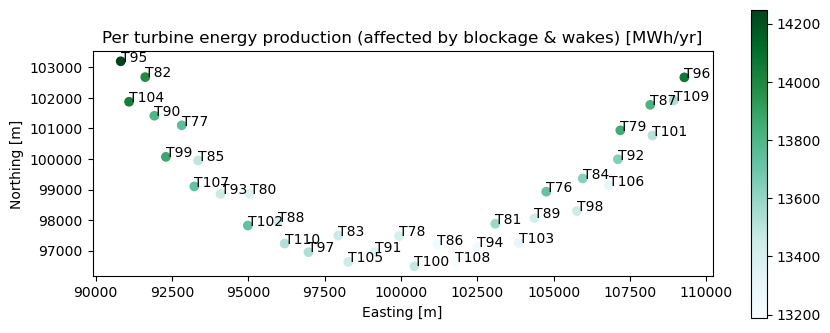

In [6]:
result_set_to_plot = "cfdml" # select one of the 3 previously defined configs: cfdml / ev+lwf+beet / ev+lwf+beet_ws
    
result = json.loads(responses_dict[result_set_to_plot].content)
full_aep_MWh_per_year = float(result['windFarmAepOutputs'][0]['fullAnnualEnergyYield_MWh_per_year'])
print(f'Wake & Blockage Affected Annual Energy Production = {full_aep_MWh_per_year:.1f} MWh / year')
#plot  per-turbine yield
per_turbine_results = pd.DataFrame.from_dict(result['windFarmAepOutputs'][0]['turbineResults'])
per_turbine_results['easting'] = per_turbine_results['turbineLocation'].map(lambda x: dict(x)['easting_m'])
per_turbine_results['northing'] = per_turbine_results['turbineLocation'].map(lambda x: dict(x)['northing_m'])
fig, ax = plt.subplots(figsize=(10,4))
im = ax.scatter(per_turbine_results['easting'], per_turbine_results['northing'], c=per_turbine_results['fullAnnualYield_MWh_per_year'], cmap='BuGn')
ax.set_title("Per turbine energy production (affected by blockage & wakes) [MWh/yr]")
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
ax.set_aspect('equal', adjustable='box')
for wt in per_turbine_results.iterrows():
    ax.annotate(wt[1]['turbineName'],[wt[1]['easting'], wt[1]['northing']] )
fig.colorbar(im)

# Inflow pattern under southern winds

Let's see how the inflow pattern varies with model.
 - With EV+LWF+BEET, the inflow wind speed is equal to 8 m/s (the ambient wind speed in that case), which is expected, as EV does not account for upstream or lateral effect in the flow, and BEET is applied ex-post, as a energy-based correction.
 - When BEET is applied as a wind speed perturbation (EV+LWF+BEET_WS), prior to the power conversion step, we see a unfirom reduction in the incoming wind speed.
 - Finally, CFD.ML is able to resolve the per-turbine effects of blockage.  

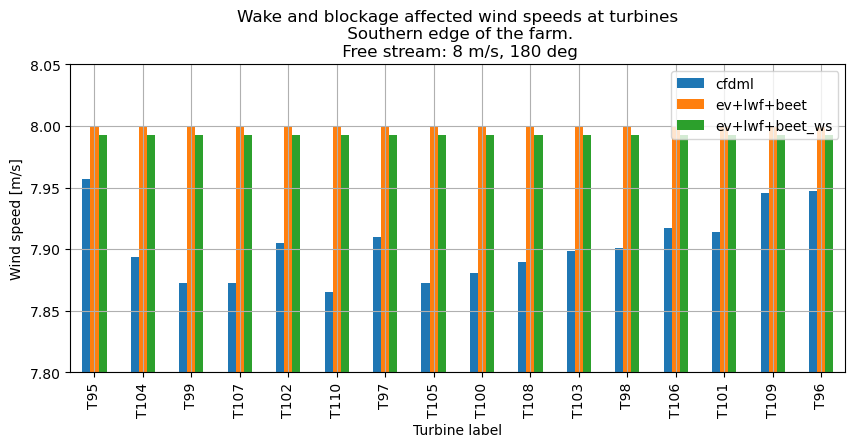

In [7]:
southern_edge = ['T95', 'T104', 'T99', 'T107', 'T102', 'T110', 'T97', 'T105', 'T100', 'T108', 'T103', 'T98', 'T106', 'T101', 'T109', 'T96']
n_dir_steps = len(result['windFarmAepOutputs'][0]['turbineFlowAndPerformanceMatricesWithMastBinning'][0]['wakedWindSpeed_m_per_s'])
idx_dir = int(180 / (360.0 / n_dir_steps) + 1)
idx_ws = 8
# extract results
front_row_waked_windspeeds_dict = {}
for k,v in responses_dict.items():
    result = json.loads(v.content)
    waked_windspeeds = pd.DataFrame(result['windFarmAepOutputs'][0]['turbineFlowAndPerformanceMatricesWithMastBinning'])
    waked_windspeeds.set_index('turbineName', drop=True, inplace=True)
    waked_windspeeds['wakedWindSpeed_at_8_m_per_s_at_180_deg'] = waked_windspeeds['wakedWindSpeed_m_per_s'].map(lambda x: round(x[idx_dir][idx_ws],3))
    front_row_waked_windspeeds_dict[k] = waked_windspeeds
# Plot
fix, ax = plt.subplots(figsize=(10,4))
concat = pd.concat([x.loc[southern_edge]['wakedWindSpeed_at_8_m_per_s_at_180_deg'] for x in front_row_waked_windspeeds_dict.values()], axis=1)
concat.columns = [x for x in front_row_waked_windspeeds_dict.keys()]
concat.plot(kind='bar', ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, concat.columns)
ax.set_title('Wake and blockage affected wind speeds at turbines\n Southern edge of the farm.\n Free stream: 8 m/s, 180 deg')
ax.set_ylabel('Wind speed [m/s]')
ax.set_xlabel('Turbine label')
ax.set_ylim([7.8,8.05])
ax.grid(True)